In [2]:
# survival analysis/regresion

# no. of months
# avg quaterly rating/ change in quterly rating since first month/last quarter
# inc in salary (absolute/perc?)
# current salary
# no. promotions (change in designations)
# current designation
# sum of total business value until now
# change in business value wrt last month/last 2 months
# total business value of last month?

# censored data - data is biased towards employees who haven't churned yet -> read more about censored data

# cph plot/kp curves to see which variables have a higher effect on churn

In [165]:
# Setup

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter 

In [4]:
data = pd.read_csv('train.csv')
# test_ids = pd.read_csv('test.csv')
data.head() 

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


In [5]:
data.tail()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
19099,2017-08-01,2788,30,Male,C27,Master,70254,2017-06-08,NaN,2,2,740280,3
19100,2017-09-01,2788,30,Male,C27,Master,70254,2017-06-08,NaN,2,2,448370,3
19101,2017-10-01,2788,30,Male,C27,Master,70254,2017-06-08,NaN,2,2,0,2
19102,2017-11-01,2788,30,Male,C27,Master,70254,2017-06-08,NaN,2,2,200420,2
19103,2017-12-01,2788,30,Male,C27,Master,70254,2017-06-08,NaN,2,2,411480,2


In [6]:
data.describe()

,Emp_ID,Age,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating
count,19104.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,1415.591133,34.650283,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,810.705321,6.264471,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,1.000000,21.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,710.000000,30.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,1417.000000,34.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,2137.000000,39.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,2788.000000,58.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
MMM-YY                  19104 non-null object
Emp_ID                  19104 non-null int64
Age                     19104 non-null int64
Gender                  19104 non-null object
City                    19104 non-null object
Education_Level         19104 non-null object
Salary                  19104 non-null int64
Dateofjoining           19104 non-null object
LastWorkingDate         1616 non-null object
Joining Designation     19104 non-null int64
Designation             19104 non-null int64
Total Business Value    19104 non-null int64
Quarterly Rating        19104 non-null int64
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


In [8]:
data.shape

(19104, 13)

In [9]:
data.nunique()

MMM-YY                     24
Emp_ID                   2381
Age                        36
Gender                      2
City                       29
Education_Level             3
Salary                   2383
Dateofjoining             869
LastWorkingDate           493
Joining Designation         5
Designation                 5
Total Business Value    10181
Quarterly Rating            4
dtype: int64

A modified dataset needs to be created using the information from the given 'train' file with one row for each employee ID.

Features from data
- current age (numeric)
- gender (binary)
- city (label incoding)
- education level (label encoding)

New/modified features
- no. of months 
- avg quaterly rating
- no. of salary increments
- current salary
- no. promotions (change in designations)
- current designation level
- sum of total business value until now
- total business value of last month?
- if the employee has left the company (yet) or not: 1 for left, 0 for not

In [10]:
emp_id = data.Emp_ID.unique() # 1 to 2788 with certain values missing


In [136]:
columns = ['Current Age','Gender','City','Education','No. of Months', 'Current Salary',
           'Current Designation', 'No. of Promotions', 'Average Business Value',
           'Business Value (present month)', 'Current Quarterly Rating','Average Quaterly Rating','Employee Status']

df = []

for ID in emp_id:
    emp = data.loc[data['Emp_ID'] == ID]
    
    age = emp.iloc[-1,2]
    gender = emp.iloc[-1,3]
    
    city_string = emp.iloc[-1,4] # city code
    city = city_string[1:] # extracting only number as a str
    city = int(city)
    
    edu = emp.iloc[-1,5]
    no_months = emp.shape[0] #no of rows
    curr_sal = emp.iloc[-1,6]
#     no_incr = emp['Salary'].nunique() -1 # no of incr = no of uniuqe values -1: salary inc = promotions
    curr_desig = emp.iloc[-1, 10]
    no_prom = emp['Designation'].nunique() -1 # no of prom = no of uniuqe values -1
#     cum_bv = emp['Total Business Value'].sum()
    avg_bv = emp['Total Business Value'].mean()
    
    bv = emp.iloc[-1, 11]
#     if no_months > 1: # previous values only exist if employee worked for >1 month
#         prev_bv = emp.iloc[-2, 11]
#         perc_bv = (bv- prev_bv)/(prev_bv + 0.00000000001) # relative change with epsilon to avoid division by zero
#     else:
#         perc_bv = np.na
    
    curr_qr = emp.iloc[-1, 12]
    avg_qr = emp['Quarterly Rating'].mean()
    
    #status 1 for left, 0 for still working
    status = 0 # default value
    if emp['LastWorkingDate'].nunique() == 1: # value exists in last row = employee resigned
        status = 1
    
    df.append([age, gender, city, edu, no_months, curr_sal, curr_desig, no_prom, 
           avg_bv, bv, curr_qr, avg_qr, status])
    
df = pd.DataFrame(df, columns = columns, index = emp_id)
df.head()

,Current Age,Gender,City,Education,No. of Months,Current Salary,Current Designation,No. of Promotions,Average Business Value,Business Value (present month),Current Quarterly Rating,Average Quaterly Rating,Employee Status
1,28,Male,23,Master,3,57387,1,0,571860.0,0,2,2.0,1
2,31,Male,7,Master,2,67016,2,0,0.0,0,1,1.0,0
4,43,Male,13,Master,5,65603,2,0,70000.0,0,1,1.0,1
5,29,Male,9,College,3,46368,1,0,40120.0,0,1,1.0,1
6,31,Female,11,Bachelor,5,78728,3,0,253000.0,0,2,1.6,0


In [137]:
# label encoding for Gender and Education

encoderL = LabelEncoder()
df['Gender'] = encoderL.fit_transform(df['Gender'])
df['Education'] = encoderL.fit_transform(df['Education']) #ohe could also be done instead
df.head()

,Current Age,Gender,City,Education,No. of Months,Current Salary,Current Designation,No. of Promotions,Average Business Value,Business Value (present month),Current Quarterly Rating,Average Quaterly Rating,Employee Status
1,28,1,23,2,3,57387,1,0,571860.0,0,2,2.0,1
2,31,1,7,2,2,67016,2,0,0.0,0,1,1.0,0
4,43,1,13,2,5,65603,2,0,70000.0,0,1,1.0,1
5,29,1,9,1,3,46368,1,0,40120.0,0,1,1.0,1
6,31,0,11,0,5,78728,3,0,253000.0,0,2,1.6,0


In [169]:
df.describe()

,Current Age,Gender,City,Education,No. of Months,Current Salary,Current Designation,No. of Promotions,Average Business Value,Business Value (present month),Current Quarterly Rating,Average Quaterly Rating,Employee Status
count,2381.000000,2381.000000,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,33.663167,0.589668,15.335573,1.002940,8.02352,0.273467,2.096598,0.018480,0.122305,0.036179,1.427971,1.566304,0.678706
std,5.983375,0.491997,8.371843,0.819146,6.78359,0.159754,0.941522,0.134706,0.107809,0.032664,0.809839,0.719652,0.467071
min,21.000000,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,29.000000,0.000000,8.000000,0.000000,3.00000,0.159604,1.000000,0.000000,0.047465,0.028499,1.000000,1.000000,0.000000
50%,33.000000,1.000000,15.000000,1.000000,5.00000,0.250846,2.000000,0.000000,0.083586,0.028499,1.000000,1.000000,1.000000
75%,37.000000,1.000000,22.000000,2.000000,10.00000,0.367190,3.000000,0.000000,0.150461,0.034168,2.000000,2.000000,1.000000
max,58.000000,1.000000,29.000000,2.000000,24.00000,1.000000,5.000000,1.000000,1.000000,1.000000,4.000000,4.000000,1.000000


In [139]:
# scalling current salary and avg business value

scaler = MinMaxScaler()
col_list = ['Current Salary', 'Average Business Value','Business Value (present month)']
scaled = scaler.fit_transform(df[col_list])

scaled = pd.DataFrame(scaled, columns = col_list, index = emp_id)

df.drop(columns = col_list, inplace = True)
df.insert(5, col_list[0],scaled['Current Salary'])
df.insert(8, col_list[1],scaled['Average Business Value'])
df.insert(9, col_list[2],scaled['Business Value (present month)'])
df.head()

,Current Age,Gender,City,Education,No. of Months,Current Salary,Current Designation,No. of Promotions,Average Business Value,Business Value (present month),Current Quarterly Rating,Average Quaterly Rating,Employee Status
1,28,1,23,2,3,0.262508,1,0,0.184600,0.028499,2,2.0,1
2,31,1,7,2,2,0.316703,2,0,0.047465,0.028499,1,1.0,0
4,43,1,13,2,5,0.308750,2,0,0.064252,0.028499,1,1.0,1
5,29,1,9,1,3,0.200489,1,0,0.057086,0.028499,1,1.0,1
6,31,0,11,0,5,0.382623,3,0,0.108136,0.028499,2,1.6,0


Text(0.5,1,'Count of Education')

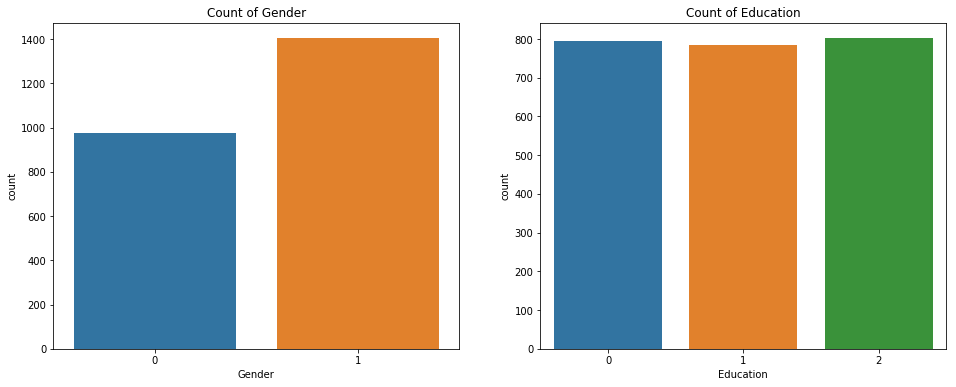

In [140]:
f, axes = plt.subplots(1,2, figsize=(16, 6))
sns.countplot(x="Gender",  data=df, ax = axes[0])
sns.countplot(x="Education",  data=df, ax = axes[1])

axes[0].set_title('Count of Gender')
axes[1].set_title('Count of Education')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001695DDB8860>,
      dtype=object)

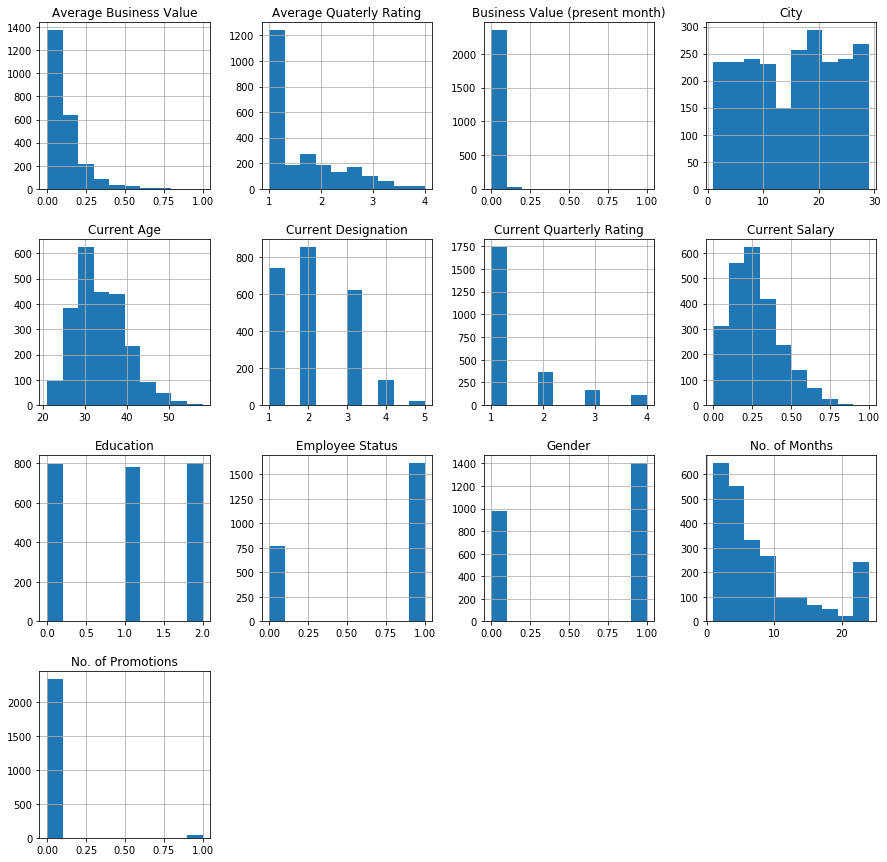

In [141]:
# Histogram to visualize data
df.hist(figsize = (15,15))

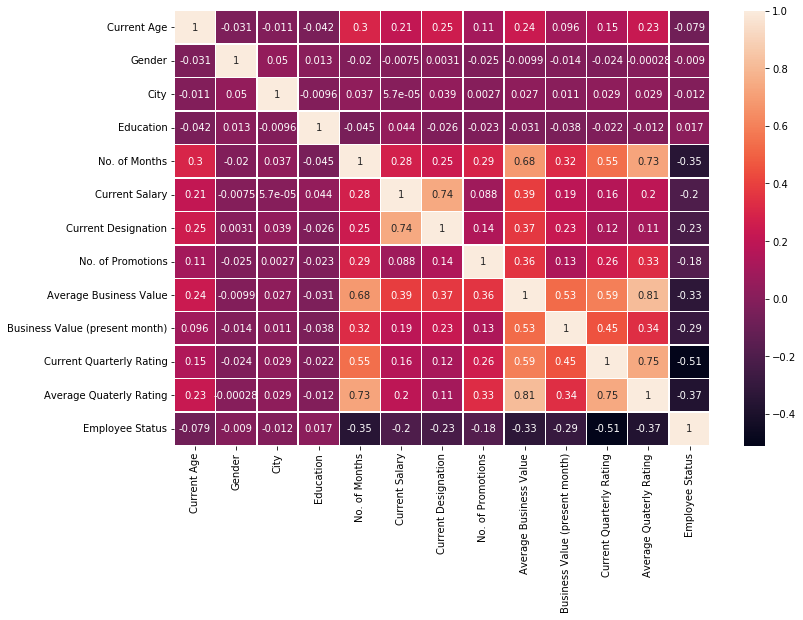

In [142]:
plt.figure(figsize=(12,8))

sns.heatmap(df.corr(),linewidths=.5,annot = True)

In [ ]:
# plot hist again with status as legend

### Survival Analysis

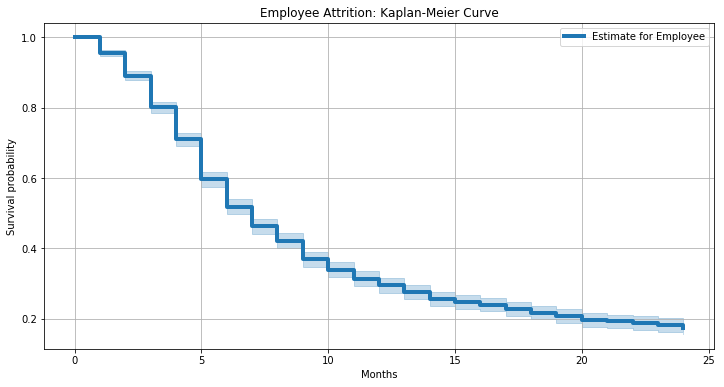

In [143]:
kmf = KaplanMeierFitter()

kmf.fit(durations = df['No. of Months'], event_observed = df['Employee Status'], 
        label = 'Estimate for Employee')

kmf.plot(linewidth=4, figsize=(12, 6))
plt.title('Employee Attrition: Kaplan-Meier Curve')
plt.xlabel('Months')
plt.ylabel('Survival probability')
plt.grid()

#suvival probability is approx 0.5 after 6 months

In [149]:
cph = CoxPHFitter()
cph.fit(df, duration_col = 'No. of Months', event_col = 'Employee Status')

# Print model summary
cph.print_summary(model = 'base model', decimals = 3, columns = ['coef', 'exp(coef)', 'p']) 

<lifelines.CoxPHFitter: fitted with 2381 observations, 765 censored>
      duration col = 'No. of Months'
         event col = 'Employee Status'
number of subjects = 2381
  number of events = 1616
    log-likelihood = -10320.295
  time fit was run = 2021-11-21 13:33:30 UTC
             model = base model

           columns = ['coef', 'exp(coef)', 'p']


---
                                  coef  exp(coef)  se(coef)       z       p  -log2(p)  lower 0.95  upper 0.95
Current Age                     -0.003      0.997     0.004  -0.609   0.543     0.882      -0.011       0.006
Gender                          -0.014      0.987     0.051  -0.266   0.791     0.339      -0.113       0.086
City                            -0.002      0.998     0.003  -0.578   0.563     0.828      -0.007       0.004
Education                        0.054      1.055     0.031   1.730   0.084     3.581      -0.007       0.115
Current Salary                  -0.283      0.754     0.250  -1.130   0.258     1.953    

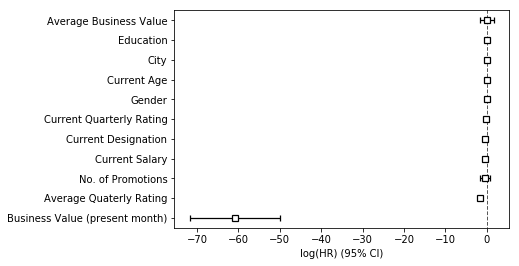

In [150]:
# comment on coef values, concordance value

# city and age coeff have values significanty closest to zero
# positive value increase chances of employee quitting

cph.plot()

In [159]:
# The Concordance Index does not say anything about the model’s calibration i.e., how far are the predicted probabilities from the actual true probabilities.
# We can draw a calibration curve to check this propensity of our model to predict probabilities at any given time correctly.

avg_score = np.mean(lifelines.utils.k_fold_cross_validation(cph, df, 'No. of Months','Employee Status', k = 5))
print('The average Concordance Score across 5 folds is: {:.3f}'.format(avg_score))

The average Concordance Score across 5 folds is: 0.827


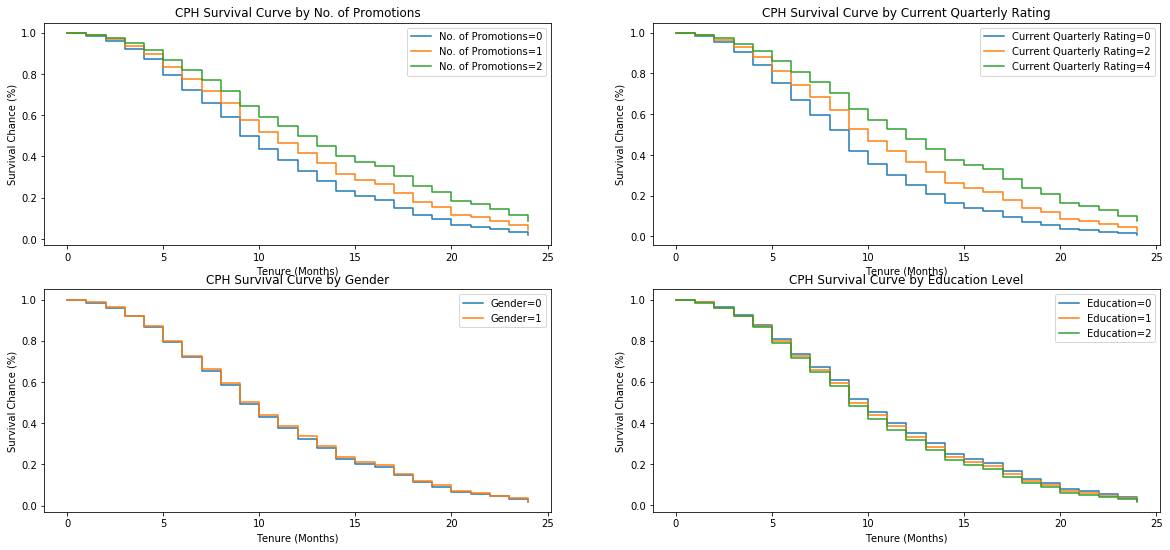

In [180]:
# plot CPH survival curves over various covariate values
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20,9))

cph.plot_covariate_groups('No. of Promotions', values = [0, 1, 2], ax = ax1, plot_baseline=False)
ax1.set_title('CPH Survival Curve by No. of Promotions')
ax1.set_xlabel('Tenure (Months)')
ax1.set_ylabel('Survival Chance (%)')

cph.plot_covariate_groups('Current Quarterly Rating', values = [0,2,4], ax = ax2, plot_baseline=False)
ax2.set_title('CPH Survival Curve by Current Quarterly Rating')
ax2.set_xlabel('Tenure (Months)')
ax2.set_ylabel('Survival Chance (%)')
      
cph.plot_covariate_groups('Gender', values = [0, 1], ax = ax3, plot_baseline=False)
ax3.set_title('CPH Survival Curve by Gender')
ax3.set_xlabel('Tenure (Months)')
ax3.set_ylabel('Survival Chance (%)')

cph.plot_covariate_groups('Education', values = [0,1,2], ax = ax4, plot_baseline=False)
ax4.set_title('CPH Survival Curve by Education Level')
ax4.set_xlabel('Tenure (Months)')
ax4.set_ylabel('Survival Chance (%)');

# comment of insights

Text(0.5,1,'Calibration plots (reliability curve) for the 6th month')

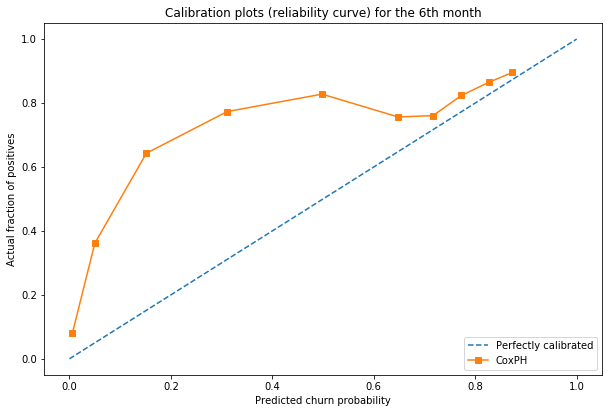

In [164]:
# Plot calibration curve at t=6
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2) 
# Plot the perfectly calibrated line with 0 intercept and 1 slope
ax1.plot([0, 1], [0, 1], ls = '--', label = 'Perfectly calibrated') 
# Calculate the "churn" probabilities at the end of 6th month
probs = 1 - np.array(cph.predict_survival_function(df, times = 6).T)
actual = df['Employee Status'] 
# get the info required to plot a calibration curve for 10 deciles
fraction_of_positives, mean_predicted_value = calibration_curve(actual, probs, n_bins = 10, strategy = 'quantile') 
ax1.plot(mean_predicted_value, fraction_of_positives, marker = 's', ls = '-', label='CoxPH') 
ax1.set_ylabel("Actual fraction of positives") 
ax1.set_xlabel("Predicted churn probability")
ax1.set_ylim([-0.05, 1.05]) 
ax1.legend(loc="lower right") 
ax1.set_title('Calibration plots (reliability curve) for the 6th month')

# the model highly under-predicted the churn risk (employee leaving) for the first 6 deciles 
# but gives reasonable prediction for the last four

The Brier Score of our CPH Model is 0.22 at the end of 6 months


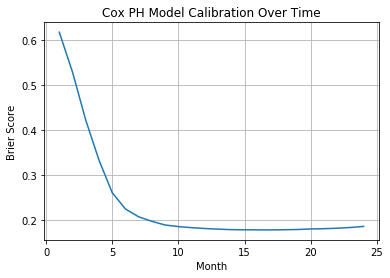

In [168]:
# calculate Brier Score
brier_score = brier_score_loss(df['Employee Status'], 1 - np.array(cph.predict_survival_function(df, times = 6).T), pos_label = 1)
print('The Brier Score of our CPH Model is {:.2f} at the end of 6 months'.format(brier_score))

# plot brier score for the next 24 months
brier_score_dict = {} 
# Loop over all the months
for i in range(1,25): 
    score = brier_score_loss(df['Employee Status'], 1 - np.array(cph.predict_survival_function(df, times = i).T), pos_label=1) 
    brier_score_dict[i] = [score] 
# Convert the dict to a DF
brier_score_df = pd.DataFrame(brier_score_dict).T 
# Plot the Brier Score over time
fig, ax = plt.subplots() 
ax.plot(brier_score_df) 
ax.set(xlabel='Month', ylabel='Brier Score', title='Cox PH Model Calibration Over Time') 
ax.grid()

# low score is better
# model is well calibrated after 6-7th month

In [206]:
# churn prediction

df_test = df.filter(items = test_ids.Emp_ID.tolist(), axis=0)    
df_test.head()

,Current Age,Gender,City,Education,No. of Months,Current Salary,Current Designation,No. of Promotions,Average Business Value,Business Value (present month),Current Quarterly Rating,Average Quaterly Rating,Employee Status
394,34,0,20,2,24,0.489528,4,0,0.321824,0.106275,3,2.125,0
173,39,1,28,1,24,0.255680,3,0,0.245966,0.048823,3,2.750,0
1090,39,1,13,1,24,0.484058,4,0,0.550880,0.072213,2,2.750,0
840,40,0,8,1,24,0.439385,4,0,0.218666,0.061657,2,1.500,0
308,32,1,5,2,24,1.000000,5,0,0.627238,0.137111,2,2.625,0


In [217]:
# Predict the survival function for each customer from this day onwards
conditioned_sf = cph.predict_survival_function(X = df_test)

conditioned_sf.head(7)

,394,173,1090,840,308,1864,1606,954,2422,1841,...,2725,2314,819,2189,2251,2134,2255,448,1644,624
event_at,,,,,,,,,,,,,,,,,,,,,
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.999975,0.999424,0.999904,0.998478,0.999999,0.999857,0.999379,0.999517,0.999947,0.999587,...,0.999711,0.999948,0.999709,0.999156,0.998357,0.999675,0.999946,1.000000,0.998985,0.998943
2.0,0.999932,0.998413,0.999736,0.995810,0.999997,0.999607,0.998289,0.998670,0.999854,0.998863,...,0.999202,0.999855,0.999197,0.997676,0.995476,0.999105,0.999851,0.999999,0.997203,0.997089
3.0,0.999859,0.996720,0.999453,0.991353,0.999994,0.999187,0.996464,0.997250,0.999698,0.997649,...,0.998351,0.999701,0.998340,0.995200,0.990666,0.998150,0.999693,0.999999,0.994224,0.993988
4.0,0.999762,0.994469,0.999077,0.985448,0.999989,0.998628,0.994039,0.995363,0.999491,0.996035,...,0.997218,0.999495,0.997200,0.991911,0.984296,0.996880,0.999481,0.999998,0.990269,0.989873
5.0,0.999611,0.990978,0.998492,0.976330,0.999983,0.997758,0.990277,0.992434,0.999168,0.993528,...,0.995457,0.999175,0.995428,0.986815,0.974465,0.994906,0.999152,0.999997,0.984148,0.983505
6.0,0.999446,0.987192,0.997856,0.966501,0.999975,0.996813,0.986198,0.989255,0.998817,0.990808,...,0.993545,0.998826,0.993503,0.981299,0.963877,0.992762,0.998795,0.999995,0.977528,0.976620


In [215]:
# Predict the month where the survival probability falls below the median
predictions_50 = lifelines.utils.median_survival_times(conditioned_sf)

predictions_50

,394,173,1090,840,308,1864,1606,954,2422,1841,...,2725,2314,819,2189,2251,2134,2255,448,1644,624
0.5,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [247]:
df_pred = pd.DataFrame(index = test_ids.Emp_ID.tolist(), columns = ['Status'])

#<0.5 means employee quit
df_pred['Status'] = np.where(conditioned_sf.iloc[7,:] <0.5, 1, 0)
df_pred.head()

,Status
394,0
173,0
1090,0
840,0
308,0


In [254]:
df_pred.to_csv('pred.csv',index = True, header = True)